In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.interpolate import interp1d
from scipy.special import spherical_jn
from tqdm import tqdm

import mu2
from interaction import LocalSystem, potential
import constants as const
import utility
import bind

plt.style.use('science')
gr = 4/3
h = 3

In [2]:
def alpha(r):
    return 9/2 - 2/3*np.exp(-2*r) * (r**5 + 9/2*r**4 + 9*r**3 + 27/2*r**2 + 27/2*r + 27/4)


def mm_potential(r):
    return -1/2 * alpha(r) / r**4

In [28]:
# Compute the Mott-Massey results
Ri = 1.5
f = 20
nq = 520
qmax = f*10/Ri
qmesh = utility.log_mesh(0, qmax, nq)
rmesh = utility.log_mesh(0, 10*const.BETA4, 4000)
mm = LocalSystem(1.5, qmesh=(*qmesh, qmax), rmesh=rmesh)
mm_vtilde = utility.ft_matrix_gen(mm_potential, 0, 0, mm.q, mm.r_nodes, mm.r_weights)
mm_evals, mm_evecs = bind.bound_states(mm_vtilde, 0, 0, mm.q, mm.wq)

In [29]:
def ftr(state, r, q, wq):
    y = np.array([np.sum(np.sqrt(2/np.pi) * wq * q**2 * state * spherical_jn(0, q*ri)) for ri in r])
    return 1/np.sqrt(np.sum(ls.r_weights * ls.r_nodes**2 * y**2)) * y


def local_LO_counterterm(r, R):
    return np.exp(-(r/R)**4)


def M_coord(ls, evals, evecs):
    overlap = np.zeros(7)
    for i in range(7):
        psi = ftr(evecs[:, i], ls.r_nodes, ls.q, ls.wq)
        overlap[i] = np.sum(ls.r_weights * ls.r_nodes**2 * local_LO_counterterm(ls.r_nodes, ls.r_c) * psi**2)
    return overlap

def M_mom(ls, evals, evecs):
    overlap = np.zeros(7)
    norm = 1 / np.sqrt( 
        np.array([np.sum(ls.wq * ls.q**2 * evecs[:, i]**2) for i in range(7)])
    )
    for i in range(7):
        x = ls.wq * ls.q**2 * norm[i] * evecs[:, i]
        overlap[i] = x @ (ls.counterterm.gen(1, 0) @ x)
    return overlap
    
    
def evals_and_evecs(g, ls):
    return bind.bound_states(ls.v_tilde, ls.counterterm.gen(g, 0), 1, ls.q, ls.wq)


def f_root(gnlo, ls, glo, use_momentum_space=True):
    evals, evecs = evals_and_evecs(glo, ls)
    evals = evals[np.where(np.abs(evals) > 1e-9)[0]]
    assert evals.size == 7, f'There are {evals.size} bounds states.'
    

    if use_momentum_space:
        overlap = M_mom(ls, evals, evecs)
    else:
        overlap = M_coord(ls, evals, evecs)
        
    return (mm_evals[6] - evals[6]*(1 + gnlo*overlap[6])) / mm_evals[6]

In [30]:
Rs, gs = np.loadtxt('rgflow_local_lo_a0_fix_hp.txt', unpack=True)

In [90]:
index = 49
Ri = Rs[index]
gi = gs[index]

nq = 1600
f = 23
qmax = f*2/Ri

nr = 6000
rmesh = utility.log_mesh(0, 10*const.BETA4, nr)



In [ ]:
ls = LocalSystem(Ri, qmesh=(*utility.log_mesh(0, qmax, nq), qmax), rmesh=rmesh)
evals, evecs = bind.bound_states(ls.v_tilde, ls.counterterm.gen(gi, 0), 1, ls.q, ls.wq)

In [89]:
nq, f, nr, M_coord(ls, *evals_and_evecs(gi, ls))

(1300,
 23,
 6000,
 array([2.92966180e-05, 1.56026945e-05, 1.04752190e-05, 6.92651803e-06,
        3.83919650e-06, 1.55266320e-06, 2.54207740e-07]))

In [87]:
nq, f, nr, M_coord(ls, *evals_and_evecs(gi, ls))

(1200,
 23,
 6000,
 array([2.67317778e-05, 1.51872232e-05, 9.59638610e-06, 6.24657303e-06,
        3.48208547e-06, 1.49722696e-06, 2.52797768e-07]))

In [85]:
nq, f, nr, M_coord(ls, *evals_and_evecs(gi, ls))

(1200,
 22,
 6000,
 array([2.69005204e-05, 1.53151886e-05, 9.74436760e-06, 6.35034254e-06,
        3.51703693e-06, 1.50163041e-06, 2.52906544e-07]))

In [33]:
guess = 0.09
f_root(guess, ls, gi, use_momentum_space=False)

0.008195756998750314

In [15]:
class Spectrum:
    def __init__(self, ls, glo, gnlo):
        evals, evecs = bind.bound_states(ls.v_tilde, ls.counterterm.gen(glo, 0), 1, ls.q, ls.wq)
        self.lo_evals = np.copy(evals)
        self.lo_evecs = np.copy(evecs)
        self.R = ls.r_c
        self.glo = glo
        self.g_nlo = gnlo
        
        self.overlap = M_coord(ls, self.lo_evals, self.lo_evecs)
        self.nlo_evals = self.lo_evals + self.g_nlo*self.lo_evals*self.overlap

In [16]:
optimize.fsolve(f_root, guess, args=(ls, gi, False))

array([0.43611692])

In [91]:
systems = []
for i in tqdm(range(Rs.size)):
    Ri = Rs[i]
    qmax = f*2/Ri
    systems.append(
        LocalSystem(Ri, qmesh=(*utility.log_mesh(0, qmax, nq), qmax), rmesh=rmesh)
    )

 26%|███████████████████████▍                                                                  | 13/50 [59:11<2:48:27, 273.17s/it]


KeyboardInterrupt: 

In [ ]:
glos = np.zeros(Rs.size)
gnlos = np.zeros(Rs.size)
specs = []

for (i, (Ri, gi)) in enumerate(zip(Rs, gs)):
    qmax = f*2/Ri
    ls = systems[i]
    
    result = optimize.fsolve(f_root, guess, args=(ls, gi, False), xtol=1e-10)
    gnlo = result[0]
    
    glos[i] = gi
    gnlos[i] = gnlo
    specs.append(Spectrum(ls, gi, gnlo))
    
    print(f'i = {i}  R = {Ri:.4e}  g_lo = {gi:.4e}  g_nlo = {gnlo:.4e}')
    if i == Rs.size-1:
        break
    
    if i < 5:
        guess = result
    else:
        glo_curve = interp1d(Rs[i-5:i], glos[i-5:i], kind='cubic', fill_value='extrapolate')
        gnlo_curve = interp1d(Rs[i-5:i], gnlos[i-5:i], kind='cubic', fill_value='extrapolate')
        try:
            guess = np.array([glo_curve(Rs[i+1]), gnlo_curve(Rs[i+1])])
        except:
            print('Did not get a good guess.')
            break

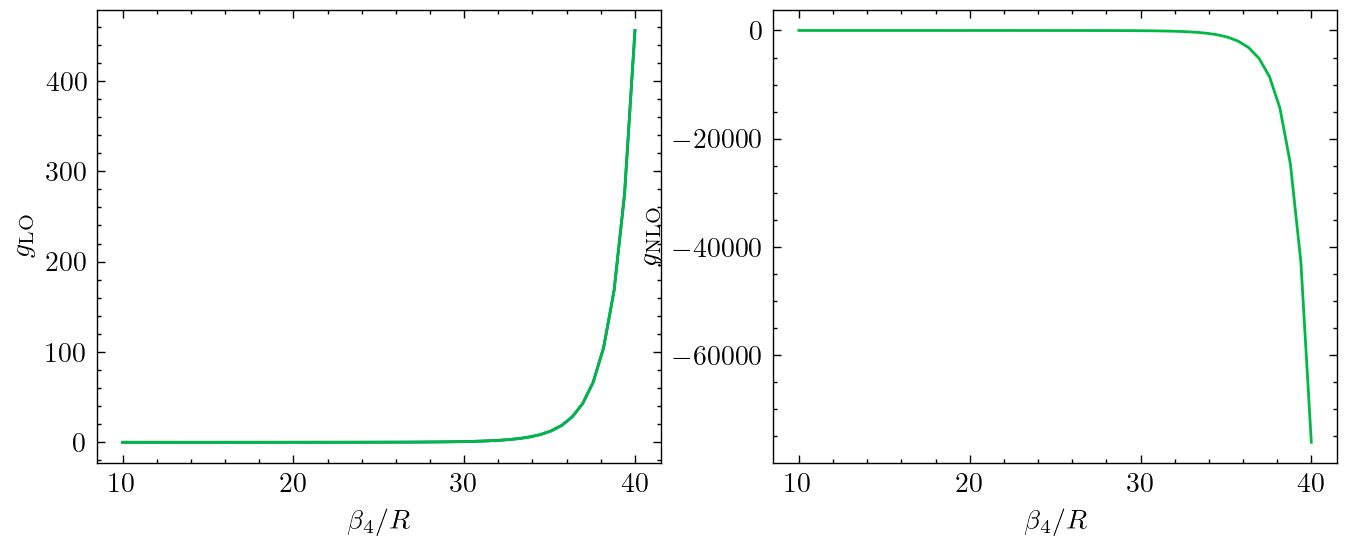

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(2*gr*h, h), dpi=200)
fig.patch.set_facecolor('white')

ax[0].plot(const.BETA4/Rs, glos)
ax[0].plot(const.BETA4/Rs, gs)
ax[1].plot(const.BETA4/Rs, gnlos, color='C1')

# ax.set_ylim([-1, 1])
ax[0].set_xlabel(r'$\beta_4/R$')
ax[0].set_ylabel(r'$g_{\rm LO}$')
ax[1].set_xlabel(r'$\beta_4/R$')
ax[1].set_ylabel(r'$g_{\rm NLO}$');

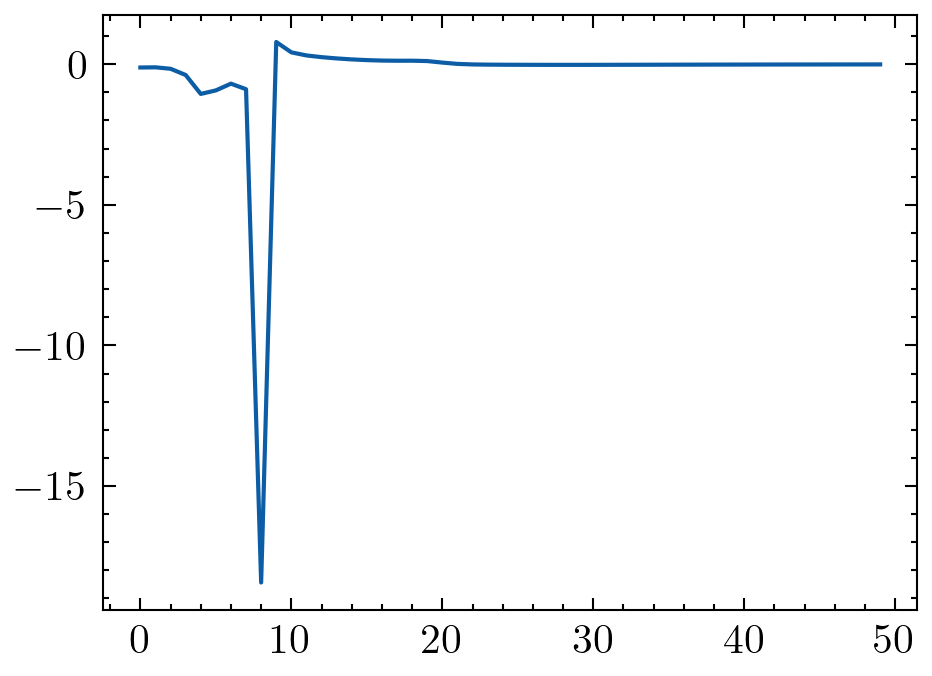

In [21]:
fig, ax = plt.subplots(dpi=300)
fig.patch.set_facecolor('white')\

ax.plot(glos/gnlos);

In [22]:
np.savetxt('rgflow_local_nlo_a0_B6_fix_hp.txt', np.vstack((Rs, glos, gnlos)).T, header='R  g_LO  g_NLO')

In [23]:
rgf_old = np.loadtxt('rgflow_local_nlo_a0_B6_fix.txt')

In [24]:
gnlos / rgf_old[:, 2]

array([  3.87747558,   4.27041535,   4.67677129,   5.11017401,
         5.68422466,   5.98943531,   6.2345185 ,   6.71019457,
       -16.39298275,   6.45461919,   6.87397405,   7.1159408 ,
         7.31188265,   7.41740783,   7.48914126,   7.46332338,
         7.34754167,   7.05861479,   6.50192838,   5.7156228 ,
         4.77301323,   3.73806094,   2.75458703,   1.96698581,
         1.43390912,   1.13526834,   0.96862218,   0.85897329,
         0.7875151 ,   0.73055388,   0.69233616,   0.65074176,
         0.6197495 ,   0.60056978,   0.5831365 ,   0.5605116 ,
         0.54901884,   0.53733925,   0.52565404,   0.5177868 ,
         0.51372458,   0.50257826,   0.50245654,   0.49401021,
         0.49218642,   0.48833562,   0.48318658,   0.47998902,
         0.4747117 ,   0.47827523])

In [25]:
lo_results = np.loadtxt('spectra_local_lo_a0_fix_hp.txt')

In [26]:
# lo_specs = np.array([spec.lo_evals for spec in specs])
nlo_specs = np.array([spec.nlo_evals for spec in specs])

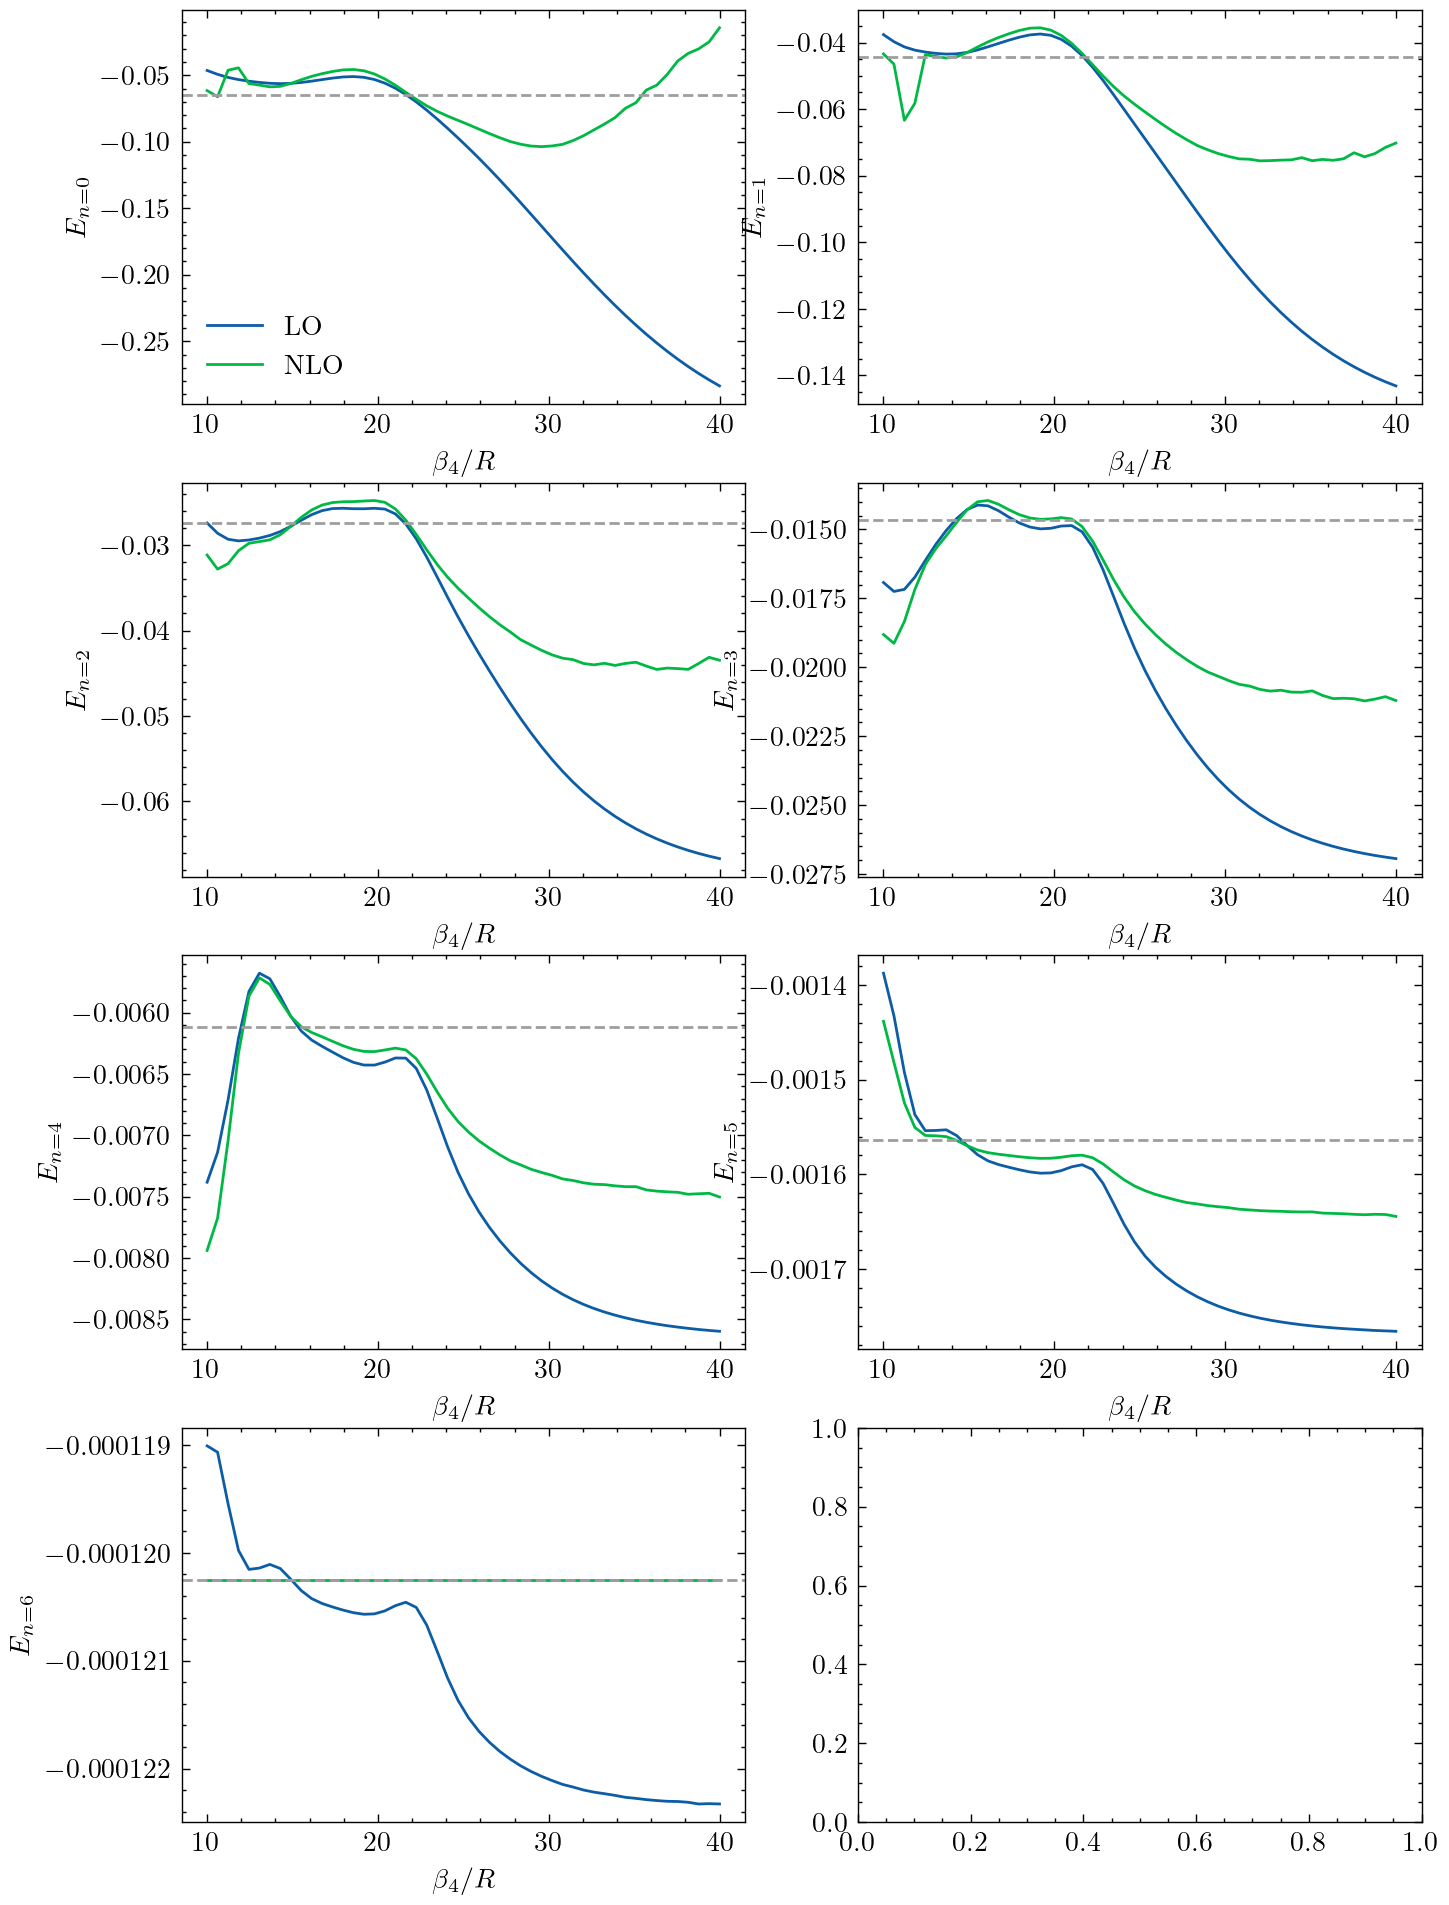

In [27]:
fig, ax = plt.subplots(4, 2, figsize=(2*gr*h, 4*h), dpi=200)
fig.patch.set_facecolor('white')

for i in range(7):
    ax[i//2, i%2].plot(const.BETA4/lo_results[:, 0], lo_results[:, i+1], label=r'LO')
    ax[i//2, i%2].plot(const.BETA4/Rs, nlo_specs[:, i], label=r'NLO')
    ax[i//2, i%2].axhline(mm_evals[i], linestyle='--', color='C6')
    ax[i//2, i%2].set_xlabel(r'$\beta_4/R$')
    ax[i//2, i%2].set_ylabel(r'$E_{n=%d}$' % (i))
    if i == 0:
        ax[0, 0].legend()

In [52]:
all_overlaps = np.array([spec.overlap for spec in specs])

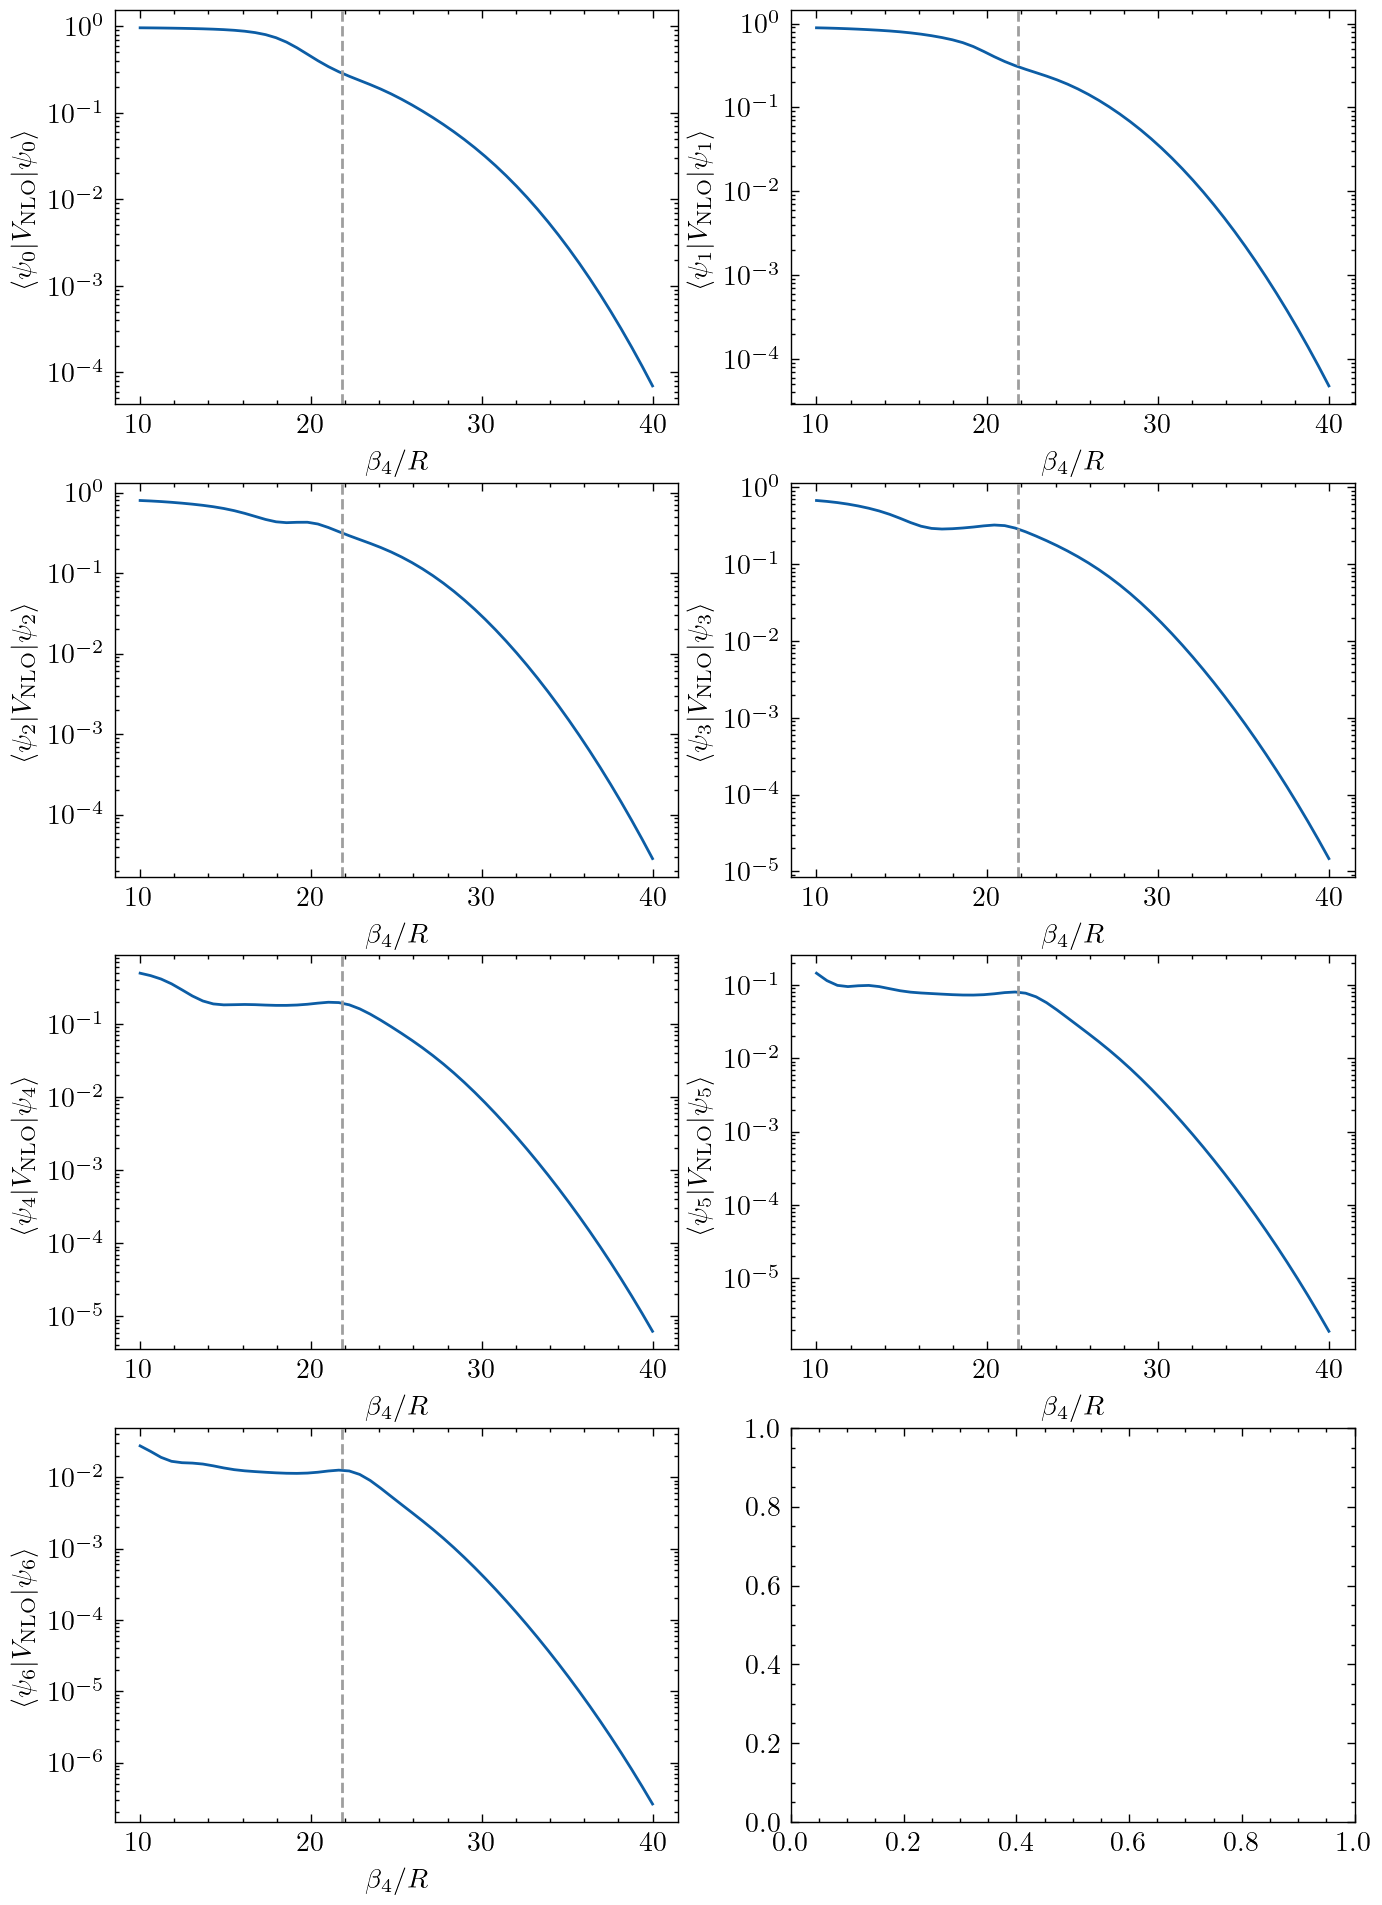

In [53]:
fig, ax = plt.subplots(4, 2, figsize=(2*gr*h, 4*h), dpi=200)
fig.patch.set_facecolor('white')

x = const.BETA4/Rs

for i in range(7):
    ax[i//2, i%2].plot(x, all_overlaps[:, i])
    ax[i//2, i%2].set_xlabel(r'$\beta_4/R$')
    ax[i//2, i%2].set_ylabel(r'$\langle\psi_{%d}|V_{\rm NLO}|\psi_{%d}\rangle$' % (i, i))
    ax[i//2, i%2].axvline(const.BETA4/1.5, linestyle='--', color='C6')
    ax[i//2, i%2].set_yscale('log')

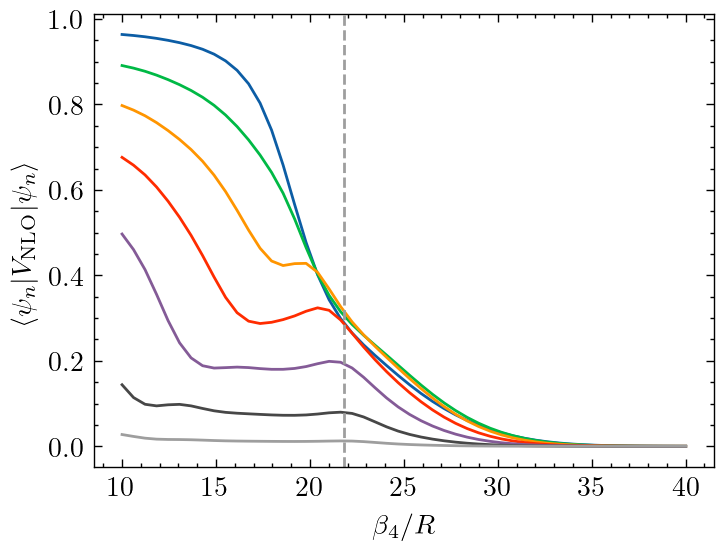

In [54]:
fig, ax = plt.subplots(figsize=(gr*h, h), dpi=200)
fig.patch.set_facecolor('white')

for i in range(7):
    ax.plot(const.BETA4/Rs, all_overlaps[:, i])
ax.set_xlabel(r'$\beta_4/R$')
ax.set_ylabel(r'$\langle\psi_{n}|V_{\rm NLO}|\psi_{n}\rangle$')
ax.axvline(const.BETA4/1.5, linestyle='--', color='C6')

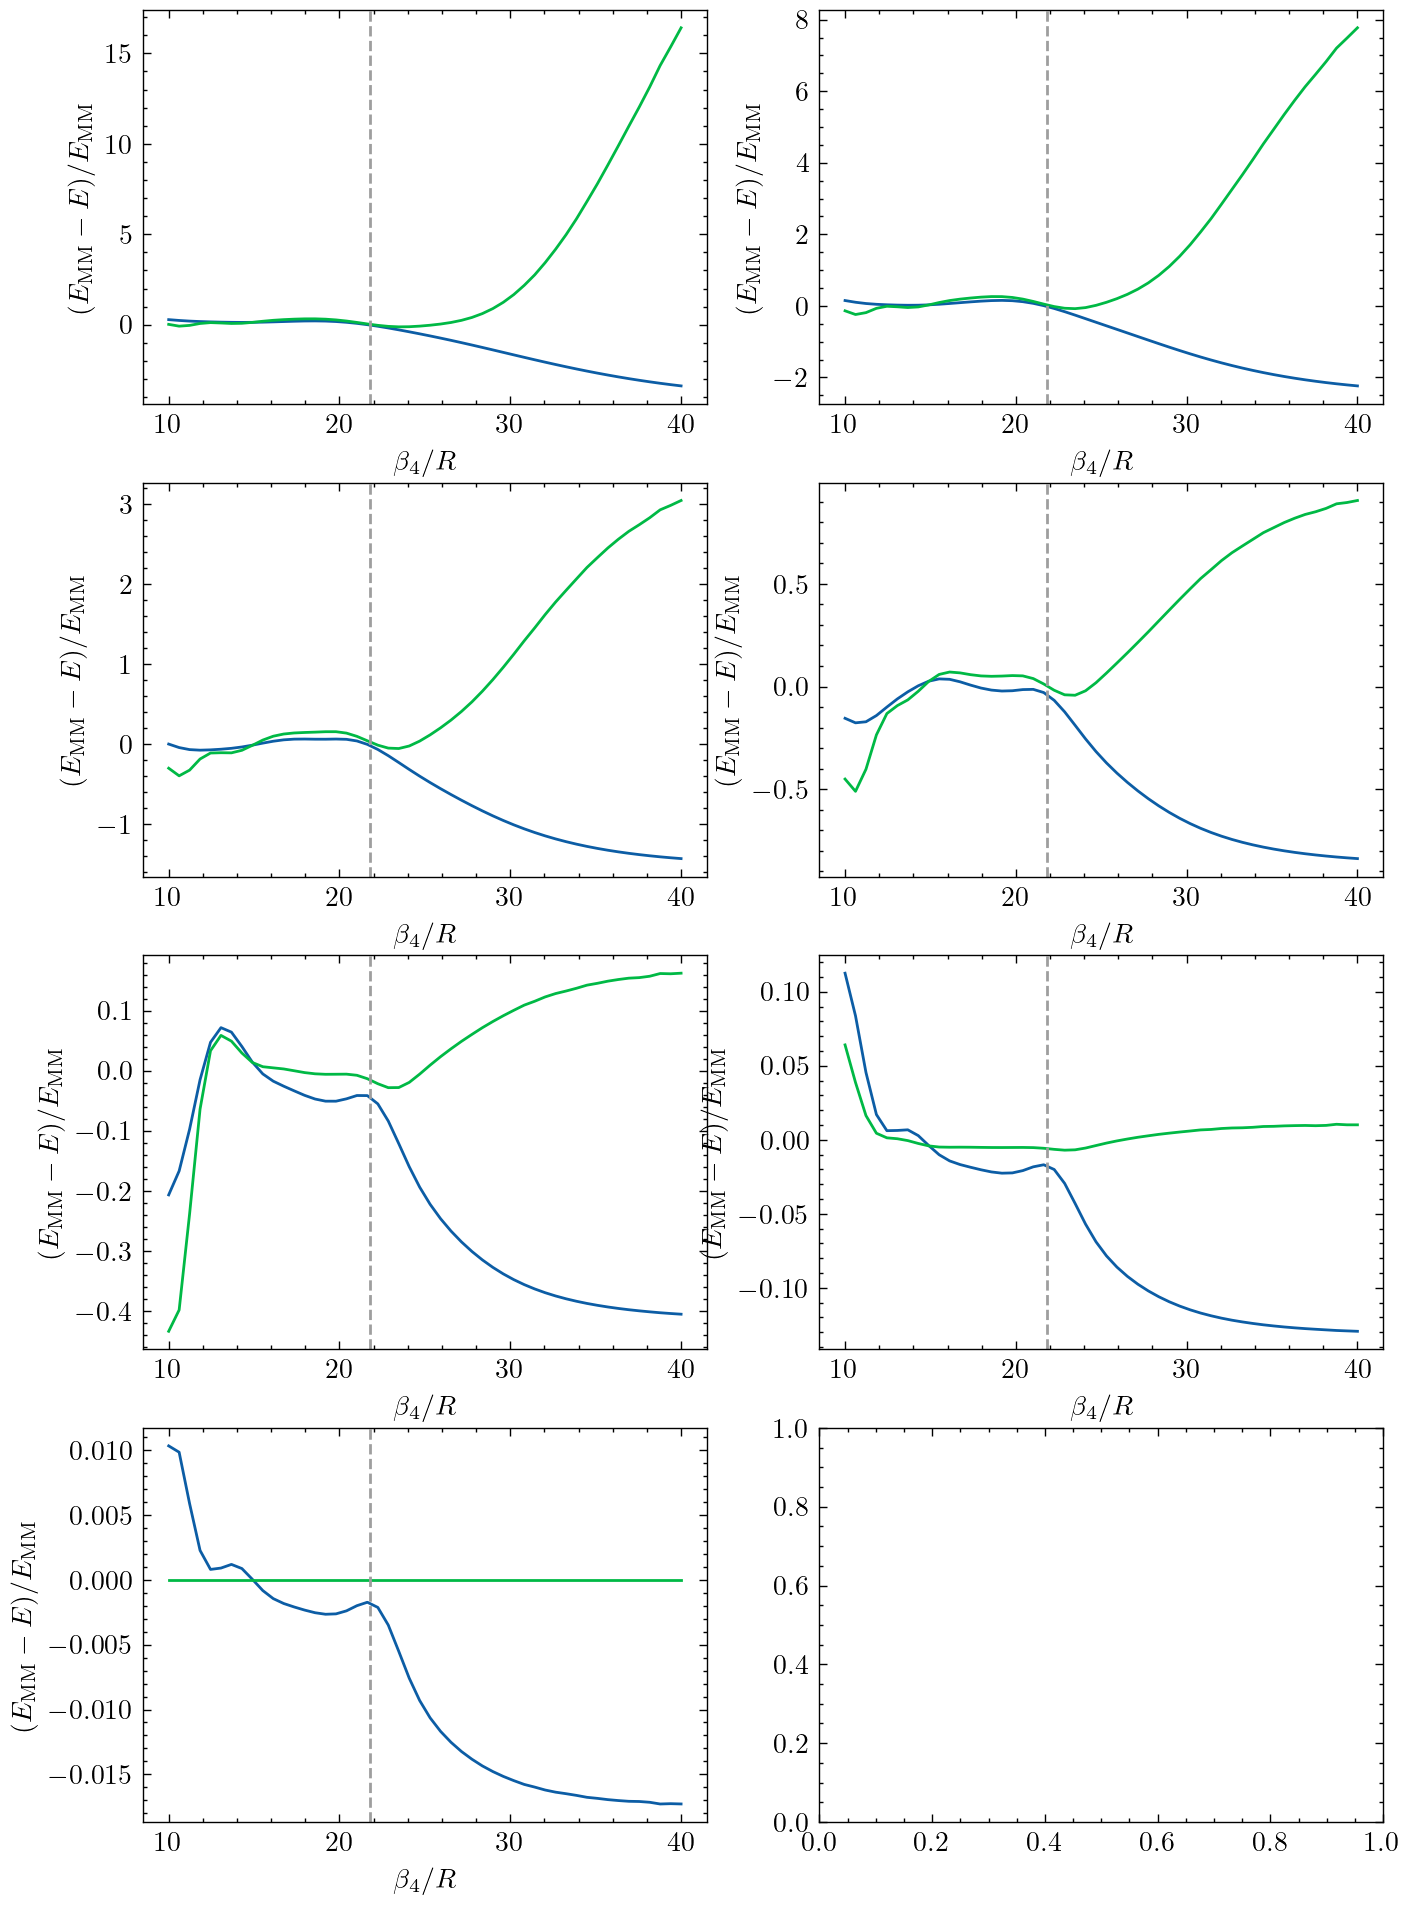

In [55]:
fig, ax = plt.subplots(4, 2, figsize=(2*gr*h, 4*h), dpi=200)
fig.patch.set_facecolor('white')

for i in range(7):
    ax[i//2, i%2].plot(const.BETA4/lo_results[:, 0], (mm_evals[i] - lo_results[:, i+1])/mm_evals[i])
    ax[i//2, i%2].plot(const.BETA4/Rs, (mm_evals[i] - nlo_specs[:, i])/mm_evals[i])
    ax[i//2, i%2].set_xlabel(r'$\beta_4/R$')
    ax[i//2, i%2].set_ylabel(r'$(E_{\rm MM}-E)/E_{\rm MM}$')
    ax[i//2, i%2].axvline(const.BETA4/1.5, linestyle='--', color='C6')

In [40]:
index = 49
sys = systems[index]
spec = specs[index]
psi_Vnlo_psi(spec.lo_evals, spec.lo_evecs, sys.r_c), M(sys, spec.lo_evals, spec.lo_evecs)

(array([1.21060353e-05, 6.50271085e-06, 4.73726093e-06, 2.89778784e-06,
        1.67179083e-06, 8.93390784e-07, 2.22502226e-07]),
 array([6.98743518e-05, 4.78110309e-05, 2.84708955e-05, 1.46652194e-05,
        6.24471114e-06, 1.90892767e-06, 2.62643004e-07]))

In [38]:
spec.overlap

array([6.98743518e-05, 4.78110309e-05, 2.84708955e-05, 1.46652194e-05,
       6.24471114e-06, 1.90892767e-06, 2.62643004e-07])

In [29]:
ls.r_c

0.8177473216915315

In [30]:
specs[-1].overlap

array([6.98743518e-05, 4.78110309e-05, 2.84708955e-05, 1.46652194e-05,
       6.24471114e-06, 1.90892767e-06, 2.62643004e-07])

In [28]:
M(ls, evals, evecs)

array([0.7435279 , 0.68743928, 0.6824243 , 0.64185256, 0.56935285,
       0.33473437, 0.11476502])

In [32]:
np.savetxt('spectra_local_nlo_a0_B6_fix_hp.txt', np.vstack((Rs, nlo_specs.T)).T,
           header ='R  E_0  E_1  E_2  E_3  E_4  E_5  E_6')

In [33]:
np.savetxt('spectra_Mott_Massey_hp.txt', mm_evals)